In [1]:
include("../scripts/kf.jl")

draw (generic function with 8 methods)

In [2]:
function make_ax()
    fig, ax = subplots()
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
    return ax
end

make_ax (generic function with 1 method)

In [3]:
function draw_trajectory(xs, ax)
    poses = [xs[s] for s in 1:length(xs)]
    ax.scatter([e[1] for e in poses], [e[2] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[1] for e in poses], [e[2] for e in poses], linewidth=0.5, color="black")
end

draw_trajectory (generic function with 1 method)

In [4]:
function draw_observations(xs, zlist, ax)
    for s in 1:length(xs)
        if !haskey(zlist, s)
            continue
        end
        for obs in zlist[s]
            x,y,theta = xs[s]
            ell,phi = obs[2][1], obs[2][2]
            mx = x + ell*cos(theta+phi)
            my = y + ell*sin(theta+phi)
            ax.plot([x,mx],[y,my], color="pink", alpha=0.5)
        end
    end
end

draw_observations (generic function with 1 method)

In [5]:
function read_data()
    f = open("log2_for_book.txt", "r")
    lines = readlines(f)
    hat_xs = Dict()
    zlist = Dict()
    delta = 0.0
    us = Dict()
    for line in lines
        tmp = split(line)
        step = parse(Int, tmp[2]) + 1#for 1-indexed
        if tmp[1] == "x"
            hat_xs[step] = [parse(Float64, tmp[3]), 
                parse(Float64, tmp[4]), parse(Float64, tmp[5])]
        elseif tmp[1] == "z"
            if !haskey(zlist, step)
                zlist[step] = []
            end
            push!(zlist[step], (parse(Int, tmp[3]), [parse(Float64, tmp[4]), 
                parse(Float64, tmp[5]), parse(Float64, tmp[6])]))
        elseif tmp[1] == "delta"
            delta = parse(Float64, tmp[2])
        elseif tmp[1] == "u"
            us[step] = [parse(Float64, tmp[3]), parse(Float64, tmp[4])]
        end
    end
    return hat_xs, zlist, us, delta
end

read_data (generic function with 1 method)

In [6]:
mutable struct ObsEdge
    t1
    t2
    x1
    x2
    z1
    z2
    omega_upperleft
    omega_upperright
    omega_bottomleft
    omega_bottomright
    xi_upper
    xi_bottom
end

In [7]:
function ObsEdge_(t1,t2,z1,z2,xs, sensor_noise_rate=[0.14, 0.05, 0.05])
    @assert z1[1] == z2[1]
    self = ObsEdge(ntuple(x->nothing, fieldcount(ObsEdge))...)
    self.t1, self.t2 = t1, t2
    self.x1, self.x2 = xs[t1], xs[t2]
    self.z1, self.z2 = z1[2], z2[2]
    
    s1 = sin(self.x1[3] + self.z1[2])
    c1 = cos(self.x1[3] + self.z1[2])
    s2 = sin(self.x2[3] + self.z2[2])
    c2 = cos(self.x2[3] + self.z2[2])
    
    hat_e = self.x2 - self.x1 + 
        [self.z2[1]*c2 - self.z1[1]*c1, 
        self.z2[1]*s2 - self.z1[1]*s1, 
        self.z2[2] - self.z2[3] - self.z1[2] + self.z1[3]]
    
    while hat_e[3] >= pi
        hat_e[3] -= 2*pi
    end
    while hat_e[3] < -pi
        hat_e[3] += 2*pi
    end
    
    Q1 = Diagonal([(self.z1[1]*sensor_noise_rate[1])^2, sensor_noise_rate[2]^2, 
            sensor_noise_rate[3]^2])
    R1 = -[c1 -self.z1[1]*s1 0;
                s1 self.z1[1]*c1 0;
                0 1 -1]
    
    Q2 = Diagonal([(self.z2[1]*sensor_noise_rate[1])^2, sensor_noise_rate[2]^2, 
            sensor_noise_rate[3]^2])
    R2 = [c2 -self.z2[1]*s2 0;
                s2 self.z2[1]*c2 0;
                0 1 -1]
    Sigma = R1* Q1 * R1' + R2*Q2*R2'
    Omega = inv(Sigma)
    
    B1 = -[1 0 -self.z1[1]*s1;
               0 1 self.z1[1]*c1;
               0 0 1]
    B2 = [1 0 -self.z2[1]*s2;
               0 1 self.z2[1]*c2;
               0 0 1]
    self.omega_upperleft = B1' * Omega * B1
    self.omega_upperright = B1' * Omega * B2
    self.omega_bottomleft = B2' * Omega * B1
    self.omega_bottomright = B2' * Omega * B2
    
    self.xi_upper = -B1' * Omega * hat_e
    self.xi_bottom = -B2' * Omega * hat_e
    return self
end

ObsEdge_ (generic function with 2 methods)

In [8]:
mutable struct MotionEdge
    t1
    t2
    hat_x1
    hat_x2
    Omega
    omega_upperleft
    omega_upperright
    omega_bottomleft
    omega_bottomright
    xi_upper
    xi_bottom
end

In [9]:
function MotionEdge_( t1, t2, xs, us, delta, 
        motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2))
    self = MotionEdge(ntuple(x->nothing, fieldcount(MotionEdge))...)
    self.t1, self.t2 = t1,t2
    self.hat_x1, self.hat_x2 = xs[t1], xs[t2]
    nu,omega = us[t2]
    if abs(omega) < 1e-5
        omega = 1e-5
    end
    M = matM(nu, omega, delta, motion_noise_stds)
    A = matA(nu, omega, delta, self.hat_x1[3])
    F = matF(nu, omega, delta, self.hat_x1[3])
    
    self.Omega = inv(A*M*A' + Matrix{Float64}(I, 3, 3)*0.0001)
    self.omega_upperleft = F' * self.Omega * F
    self.omega_upperright = -F' * self.Omega
    self.omega_bottomleft = -self.Omega * F
    self.omega_bottomright = self.Omega
    
    x2 = state_transition(IdealRobot(), nu, omega, delta, self.hat_x1)
    self.xi_upper = F' * self.Omega * (self.hat_x2 - x2)
    self.xi_bottom = -self.Omega * (self.hat_x2 - x2)
    return self
end


MotionEdge_ (generic function with 2 methods)

In [10]:
function add_edge(edge, Omega, xi)
    f1, f2 = 1+(edge.t1-1)*3, 1+(edge.t2-1)*3
    t1, t2 = f1 + 2, f2 + 2
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom
end

add_edge (generic function with 1 method)

In [11]:
function make_edges(hat_xs, zlist)
    landmark_keys_zlist = Dict()
    for step in keys(zlist)
        for z in zlist[step]
            landmark_id = z[1]
            if !haskey(landmark_keys_zlist,landmark_id)
                landmark_keys_zlist[landmark_id] = []
            end
            push!(landmark_keys_zlist[landmark_id],(step,z))
        end
    end

    edges = []
    for landmark_id in keys(landmark_keys_zlist)
        for i in 1:length(landmark_keys_zlist[landmark_id])
            for j in i+1:length(landmark_keys_zlist[landmark_id])
                xz1 = landmark_keys_zlist[landmark_id][i]
                xz2 = landmark_keys_zlist[landmark_id][j]
                push!(edges, ObsEdge_(xz1[1], xz2[1], xz1[2], xz2[2], hat_xs))
            end
        end
    end
    return edges, landmark_keys_zlist
end

make_edges (generic function with 1 method)

In [12]:
function draw_edges(edges, ax)
    for e in edges
        ax.plot([e.x1[1], e.x2[1]], [e.x1[2], e.x2[2]], color="red", alpha=0.5)
    end
end

draw_edges (generic function with 1 method)

In [13]:
function draw(xs, zlist, edges)
    ax = make_ax()
    draw_observations(xs, zlist, ax)
#     draw_edges(edges, ax)
    draw_trajectory(xs, ax)
end

draw (generic function with 9 methods)

1回目の繰り返し: 6.914803
2回目の繰り返し: 1.440370
3回目の繰り返し: 0.748941
4回目の繰り返し: 0.498692
5回目の繰り返し: 0.336992
6回目の繰り返し: 0.228264
7回目の繰り返し: 0.154907
8回目の繰り返し: 0.105341
9回目の繰り返し: 0.071824
10回目の繰り返し: 0.049146
11回目の繰り返し: 0.033795
12回目の繰り返し: 0.023402
13回目の繰り返し: 0.016364


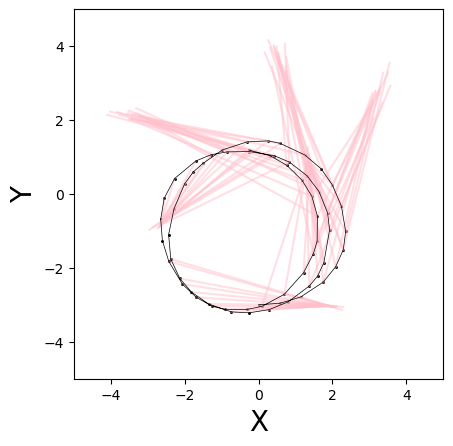

14回目の繰り返し: 0.011598
15回目の繰り返し: 0.008371


In [14]:
hat_xs, zlist, us, delta = read_data()
dim = length(hat_xs) * 3
glob_edges = []
for n in 1:10000
    edges, _ = make_edges(hat_xs, zlist)
    for i in 1:length(hat_xs)-1
        push!(edges, MotionEdge_(i, i+1, hat_xs, us, delta))
    end
    Omega = zeros(dim, dim)
    xi = zeros(dim)
    Omega[1:3, 1:3] += Matrix{Float64}(I, 3, 3) * 1000000
    
    for e in edges
        add_edge(e, Omega, xi)
    end
    
    delta_xs = inv(Omega) * xi
    
    for i in 1:length(hat_xs)
        hat_xs[i] += delta_xs[1+3*(i-1) : i*3]
    end
    
    diff = norm(delta_xs)
    println(@sprintf("%d回目の繰り返し: %f", n, diff))
    if diff < 0.01
        draw(hat_xs, zlist, edges)
        glob_edges = edges
        break
    end
end

In [15]:
_, zlist_landmark = make_edges(hat_xs, zlist)

(Any[ObsEdge(11, 39, [1.254939067220179, 1.0527256563071878, 2.592224114552515], [-0.858005161947012, 1.1371734026416038, 9.501241955085789], [4.427758172741126, 0.31720215585292566, -0.148116816246454], [2.669037708543687, -0.47510317987422784, -0.3535292098890999], [3.746958814077472 6.422484771149527 -18.69871422419051; 6.422484771149527 24.469349362286003 -67.2747511104464; -18.698714224190507 -67.2747511104464 285.48749860702355], [-3.746958814077472 -6.422484771149527 6.886901181643756; -6.422484771149527 -24.469349362286003 22.136785803415165; 18.698714224190507 67.2747511104464 -161.40550250994502], [-3.746958814077472 -6.422484771149527 18.69871422419051; -6.422484771149527 -24.469349362286003 67.2747511104464; 6.886901181643754 22.136785803415165 -161.40550250994508], [3.746958814077472 6.422484771149527 -6.886901181643756; 6.422484771149527 24.469349362286003 -22.136785803415165; -6.886901181643754 -22.136785803415165 120.58893805145706], [0.1631342521569819, 2.5356613868181

In [16]:
mutable struct MapEdge
    x
    z
    m
end

In [17]:
function MapEdge_(t, z, head_t, head_z, xs)
    self = MapEdge(ntuple(x->nothing, fieldcount(MapEdge))...)
    self.x = xs[t]
    self.z = z
    self.m = self.x + [
        z[1]*cos(self.x[3] + z[2]),
        z[1]*sin(self.x[3] + z[2]),
        -xs[head_t][3] + z[2] - head_z[2] - z[3] + head_z[3]
    ]
    while self.m[3] >= pi
        self.m[3] -= 2*pi
    end
    while self.m[3] < - pi
        self.m[3] += 2*pi
    end
    return self
end

MapEdge_ (generic function with 1 method)

In [36]:
function draw_landmarks(ms, ax)
    ax.scatter([m[1] for m in values(ms)], [m[2] for m in values(ms)], s=100, 
        marker="*", color="blue", zorder=100)
end

draw_landmarks (generic function with 1 method)

In [37]:
function draw(xs, zlist, edges, ms=[])
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    draw_landmarks(ms, ax)
end

draw (generic function with 10 methods)

In [38]:
ms = Dict()
for landmark_id in keys(zlist_landmark)
    edges = []
    head_z = zlist_landmark[landmark_id][1]
    for z in zlist_landmark[landmark_id]
        push!(edges, MapEdge_(z[1], z[2][2], head_z[1], head_z[2][2], hat_xs))
    end
    ms[landmark_id] = mean([e.m for e in edges])
end

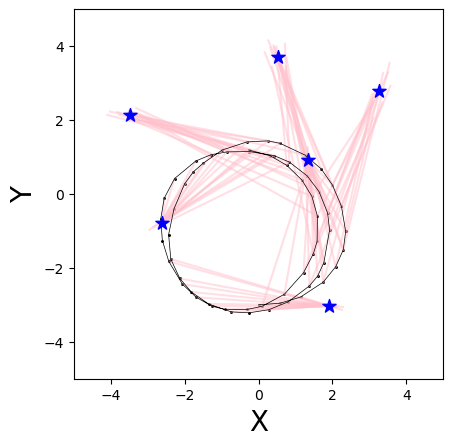

PyObject <matplotlib.collections.PathCollection object at 0x7f9b8d246760>

In [39]:
draw(hat_xs, zlist, glob_edges, ms)